Гипотеза - Если адаптировать сложность уровней под навыки игрока (динамическая сложность), retention и ARPU увеличатся.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

In [2]:

np.random.seed(42)  # фиксируем генератор случайных чисел для воспроизводимости

n_users = 20000  # всего игроков
group_ratio = [0.5, 0.5]


retention_control = 0.30  # Retention 7 дней контрольной группы
retention_test = 0.36     # Retention 7 дней тестовой группы (ожидаемый прирост)

avg_score_control = 5000  # среднее очков за сессию контрольной группы
avg_score_test = 5600     # ожидаемый прирост в тестовой группе
score_std = 1200          # стандартное отклонение очков (симулируем геймерский разброс)

levels_control = 10       # среднее количество уровней пройдено в контрольной группе
levels_test = 12          # ожидаемое увеличение уровней в тестовой группе
levels_std = 3            # стандартное отклонение количества уровней


In [3]:
user_ids = np.arange(1, n_users + 1)
groups = np.random.choice(['control', 'test'], size=n_users, p=group_ratio)

# VIP сегмент (для стратификации)
vip = np.random.choice([0,1], size=n_users, p=[0.8,0.2])

In [4]:
# Retention 7 дней (биномиальная метрика)
retention = np.where(groups=='control',
                     np.random.binomial(1, retention_control, n_users),
                     np.random.binomial(1, retention_test, n_users))

# Среднее количество очков за сессию (числовая метрика, нормальное распределение)
scores = np.where(groups=='control',
                  np.random.normal(avg_score_control, score_std, n_users),
                  np.random.normal(avg_score_test, score_std, n_users))

# Количество пройденных уровней за сессию
levels = np.where(groups=='control',
                  np.random.normal(levels_control, levels_std, n_users),
                  np.random.normal(levels_test, levels_std, n_users))

In [5]:
df = pd.DataFrame({
    'user_id': user_ids,
    'group': groups,
    'vip': vip,
    'retention_7d': retention,
    'score': scores,
    'levels_completed': levels
})


In [6]:
# Retention
ret_summary = df.groupby('group')['retention_7d'].agg(['count','sum'])
ret_summary['retention_rate'] = ret_summary['sum']/ret_summary['count']

# Среднее очков
score_summary = df.groupby('group')['score'].mean()

# Среднее количество уровней
levels_summary = df.groupby('group')['levels_completed'].mean()

print("Метрики по группам:")
print(pd.concat([ret_summary['retention_rate'], score_summary.rename('avg_score'), levels_summary.rename('avg_levels')], axis=1))


Метрики по группам:
         retention_rate    avg_score  avg_levels
group                                           
control        0.301638  4993.247622   10.011621
test           0.361834  5591.466061   11.963339


In [7]:
#Z-тест для Retention
successes = ret_summary['sum'].values
observations = ret_summary['count'].values

z_stat, p_value = proportions_ztest(successes, observations)
alpha = 0.05
if p_value < alpha:
    conclusion_ret = "Тестовая группа статистически значимо лучше контрольной по Retention."
else:
    conclusion_ret = "Нет статистически значимой разницы по Retention."

print(f"\nZ-статистика Retention: {z_stat:.3f}, P-value: {p_value:.5f}")
print("Вывод по Retention:", conclusion_ret)


Z-статистика Retention: -9.041, P-value: 0.00000
Вывод по Retention: Тестовая группа статистически значимо лучше контрольной по Retention.


In [8]:
#t-тест для очков и уровней

score_control = df[df.group=='control']['score']
score_test = df[df.group=='test']['score']

levels_control = df[df.group=='control']['levels_completed']
levels_test = df[df.group=='test']['levels_completed']

t_score, p_score = stats.ttest_ind(score_test, score_control, equal_var=False)
t_levels, p_levels = stats.ttest_ind(levels_test, levels_control, equal_var=False)

print(f"\nT-тест очков: t={t_score:.3f}, p={p_score:.5f}")
print(f"T-тест уровней: t={t_levels:.3f}, p={p_levels:.5f}")


T-тест очков: t=35.189, p=0.00000
T-тест уровней: t=46.233, p=0.00000


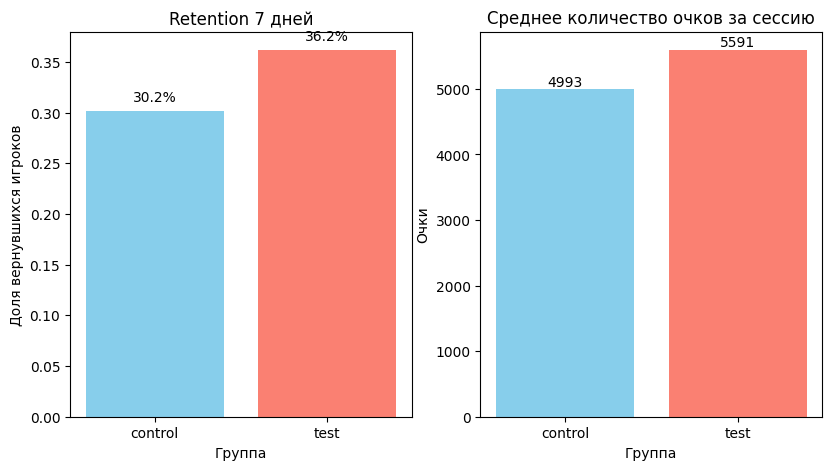

In [9]:
plt.figure(figsize=(15,5))

# Retention
plt.subplot(1,3,1)
plt.bar(ret_summary.index, ret_summary['retention_rate'], color=['skyblue','salmon'])
plt.title("Retention 7 дней")
plt.ylabel("Доля вернувшихся игроков")
plt.xlabel("Группа")
for i, v in enumerate(ret_summary['retention_rate']):
    plt.text(i, v+0.01, f"{v:.1%}", ha='center')

# Средние очки
plt.subplot(1,3,2)
plt.bar(score_summary.index, score_summary.values, color=['skyblue','salmon'])
plt.title("Среднее количество очков за сессию")
plt.ylabel("Очки")
plt.xlabel("Группа")
for i, v in enumerate(score_summary.values):
    plt.text(i, v+50, f"{v:.0f}", ha='center')

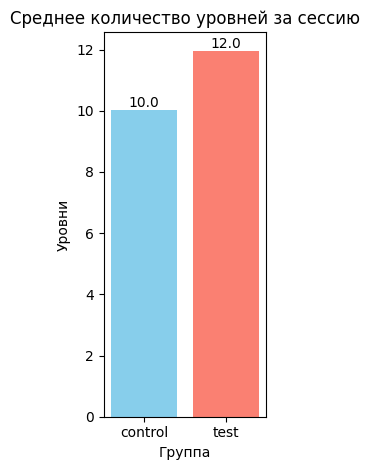

In [10]:
# Среднее количество уровней
plt.subplot(1,3,3)
plt.bar(levels_summary.index, levels_summary.values, color=['skyblue','salmon'])
plt.title("Среднее количество уровней за сессию")
plt.ylabel("Уровни")
plt.xlabel("Группа")
for i, v in enumerate(levels_summary.values):
    plt.text(i, v+0.1, f"{v:.1f}", ha='center')

plt.tight_layout()
plt.show()